In [1]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import numpy as np

In [2]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df_symbol = first_table
df_symbol

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [85]:
# df_symbol = pd.read_csv("symbols.csv")
#         company_name = yf.Ticker(element).info['shortName']
#         company_name_list.append(element)


In [130]:
import yfinance as yf
tickers = df_symbol.Symbol.values.tolist()
company_name_list = df_symbol.Security.values.tolist()

df_list = []

count = 0
for element in tickers:
    count += 1
    try:
        if count % 10 == 0:
            print(count)
        ticker = yf.Ticker(element)
        df = ticker.history(period="1y")
        df["symbol"] = element
        df["Before"] = df["Close"].shift(periods=1)
        df["return"] = np.log(df.Close/df.Before)
        df_list.append(df.dropna())
    except:
        continue


10
20
30
40
50
60
- BRK.B: No data found, symbol may be delisted
70
80
- BF.B: No data found for this date range, symbol may be delisted
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


In [194]:
df_concat = pd.concat(df_list)
df_concat["date"] = df_concat.index
df_concat = pd.merge(df_symbol, df_concat, left_on="Symbol", right_on="symbol")
df_concat = df_concat.rename(columns={"Security": "company"})

In [187]:
# df_concat["return"] = df_concat["return"].cumsum()

In [195]:
df_weighted_esg = pd.read_csv("weighted_esg.csv")

In [196]:
df_merged_final = pd.merge(df_concat, df_weighted_esg, on="company")

In [197]:
df_merged_final.columns

Index(['Symbol', 'company', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded', 'Open',
       'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'symbol',
       'Before', 'return', 'Adj Close', 'date', 'Unnamed: 0', 'tone',
       'tone_normalized', 'score', 'score_normalized', 'weighted_esg',
       'class'],
      dtype='object')

In [198]:
# stock_esg = df_merged_final[['date', 'company', 'GICS Sector', 'GICS Sub-Industry',
#        'Close', 'Volume', 'Dividends', 'Stock Splits', 'return', 'themes', 'tone',
#        'score_normalized', 'weighted_esg', 'class']]
stock_esg = df_merged_final[["date","class","return"]]

In [199]:
stock_esg.groupby(['class', 'date']).sum()

return
class date                
0     2020-11-17 -0.045500
      2020-11-18 -0.289274
      2020-11-19  0.011636
      2020-11-20 -0.217151
      2020-11-23  0.263372
...                    ...
9     2021-11-09  0.030510
      2021-11-10 -0.074944
      2021-11-11  0.139243
      2021-11-12  0.027780
      2021-11-15 -0.002927

[2510 rows x 1 columns]

Text(0.5, 1.0, 'Historical 95% VaR')

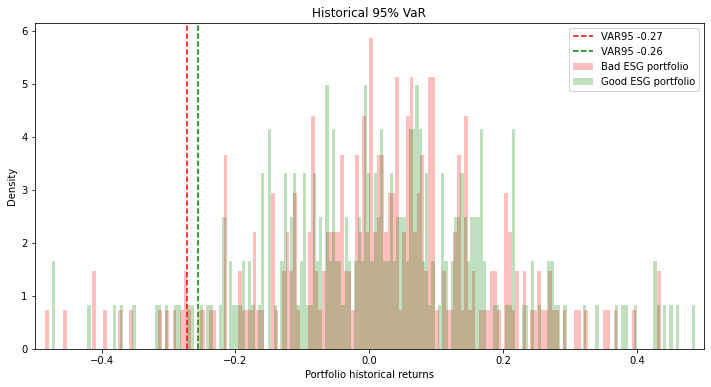

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize = (12, 6))

# create 5 different books for each ESG quantile, aggregating individual returns
grouped_assets = stock_esg.groupby(['class', 'date']).sum()

# retrieve poorly rated ESG portfolio and compute historical value at risk
bronze_portfolio = grouped_assets.loc[0]
bronze_var = np.quantile(bronze_portfolio['return'], 5 / 100)
plt.hist(bronze_portfolio['return'], bins=200, alpha=0.25, color='red', density=True, label='Bad ESG portfolio')
plt.axvline(bronze_var, color='red', linestyle='--', label="VAR95 {:.2f}".format(bronze_var))

# retrieve highly rated ESG portfolio and compute historical value at risk
gold_portfolio = grouped_assets.loc[9]
gold_var = np.quantile(gold_portfolio['return'], 5 / 100)
plt.hist(gold_portfolio['return'], bins=200, alpha=0.25, color='green', density=True, label='Good ESG portfolio')
plt.axvline(gold_var, color='green', linestyle='--', label="VAR95 {:.2f}".format(gold_var))

# plot graph
plt.xlim(-0.5,0.5)
plt.legend(loc='upper right')
plt.xlabel('Portfolio historical returns')
plt.ylabel('Density')
plt.title('Historical 95% VaR')

In [201]:
worst = df_merged_final.loc[df_merged_final.weighted_esg.argmin(),"company"]
worst

'Walmart'

In [202]:
best = df_merged_final.loc[df_merged_final.weighted_esg.argmax(),"company"]
best

'United Airlines'

<AxesSubplot:>

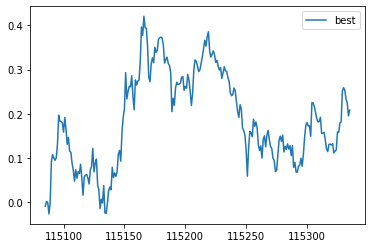

In [203]:
df_temp = pd.DataFrame()
df_temp["best"] = df_concat[df_concat.company==best]["return"].cumsum()
# df_temp["worst"] = df_concat[df_concat.company==worst]["return"].cumsum()
df_temp.plot()

<AxesSubplot:>

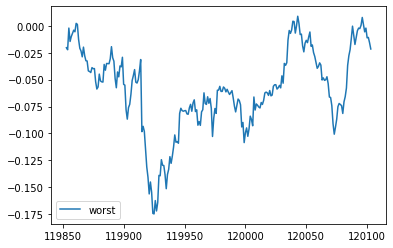

In [148]:
df_temp = pd.DataFrame()
# df_temp["best"] = df_concat[df_concat.company==best]["return"].cumsum()
df_temp["worst"] = df_concat[df_concat.company==worst]["return"].cumsum()
df_temp.plot()